In [3]:
import shutil
from glob import glob
from PIL import Image, ImageOps

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

!kaggle datasets download -d fantineh/next-day-wildfire-spread

!unzip -q ./next-day-wildfire-spread.zip # Unzipping dataset
!rm ./next-day-wildfire-spread.zip       # Removing zip file

100% 2.08G/2.08G [01:48<00:00, 23.7MB/s]
100% 2.08G/2.08G [01:48<00:00, 20.5MB/s]


In [4]:
!mkdir 'dataset'
!mkdir 'dataset/train'
!mkdir 'dataset/eval'
!mkdir 'dataset/test'
for dir in ['train', 'test', 'eval']:
  for i in sorted(glob('/content/*_{}*'.format(dir))):
    if(i.split('/')[-1].split('.')[-1] == 'tfrecord'):
      src = i
      dst = '/content/dataset/{}/'.format(dir)+i.split('/')[-1]
      shutil.move(src, dst)

## Dataloader 

In [4]:
import re
from typing import Dict, List, NamedTuple, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import shutil

In [5]:
InputImage = tf.Tensor
OutputImage = tf.Tensor
DataStatsType = Dict[str, NamedTuple]


class DataStats(NamedTuple):
    min: float
    max: float
    mean: float
    std: float


INPUT_FEATURES: List[str] = [
    'elevation', 'th', 'vs', 'tmmn', 'tmmx', 'sph', 'pr', 'pdsi',
    'NDVI', 'population', 'erc', 'PrevFireMask'
]

OUTPUT_FEATURES: List[str] = ['FireMask']

DATA_STATS: DataStatsType = {
    'elevation': DataStats(0.0, 3141.0, 657.3003, 649.0147),
    'pdsi': DataStats(-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': DataStats(-9821.0, 9996.0, 5157.625, 2466.6677),
    'pr': DataStats(0.0, 44.53038024902344, 1.7398051, 4.482833),
    'sph': DataStats(0., 1., 0.0071658953, 0.0042835088),
    'th': DataStats(0., 360.0, 190.32976, 72.59854),
    'tmmn': DataStats(253.15, 298.94891357421875, 281.08768, 8.982386),
    'tmmx': DataStats(253.15, 315.09228515625, 295.17383, 9.815496),
    'vs': DataStats(0.0, 10.024310074806237, 3.8500874, 1.4109988),
    'erc': DataStats(0.0, 106.24891662597656, 37.326267, 20.846027),
    'population': DataStats(0., 2534.06298828125, 25.531384, 154.72331),
    'PrevFireMask': DataStats(-1., 1., 0., 1.),
    'FireMask': DataStats(-1., 1., 0., 1.)
}


In [89]:
def random_crop_input_and_output_images(
    input_tensor: tf.Tensor,
    output_tensor: tf.Tensor,
    sample_size: int,
    num_input_channels: int,
    num_output_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    combined = tf.concat([input_tensor, output_tensor], axis=2)
    print(combined.shape, [sample_size, sample_size, num_input_channels + num_output_channels])
    combined = tf.image.random_crop(
        combined,
        [sample_size, sample_size, num_input_channels + num_output_channels])
    input_tensor = combined[:, :, 0:num_input_channels]
    output_tensor = combined[:, :, -num_output_channels:]
    return input_tensor, output_tensor


def center_crop_input_and_output_images(
    input_tensor: tf.Tensor,
    output_tensor: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:

    central_fraction = sample_size / input_tensor.shape[0]
    input_tensor = tf.image.central_crop(input_tensor, central_fraction)
    output_tensor = tf.image.central_crop(output_tensor, central_fraction)
    return input_tensor, output_tensor


def resize_data(
    input_tensor: tf.Tensor,
    output_tensor: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:

  SIZE = (sample_size, sample_size)
  input_tensor = tf.image.resize(input_tensor, SIZE)
  output_tensor = tf.image.resize(output_tensor, SIZE)
  output_tensor = tf.math.ceil(output_tensor, name=None)
  return input_tensor, output_tensor

In [90]:
def _get_base_key(key: Text) -> Text:
    base_key = ''.join(filter(str.isalpha, key))
    if base_key in DATA_STATS:
        return base_key
    raise ValueError(
        f'No data statistics available for the requested key: {key}.')



def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            f'No data statistics available for the requested key: {key}.')
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    if base_key=='PrevFireMask':
        rescaled_inputs = tf.math.add(inputs, 1) #
        # rescaled_inputs = tf.where(tf.equal(inputs, -1), tf.zeros_like(inputs), inputs)
    else:
      rescaled_inputs = (inputs - min_val) / (max_val - min_val)
    return tf.where(tf.math.is_finite(rescaled_inputs),
                    rescaled_inputs,
                    tf.zeros_like(rescaled_inputs))



def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            f'No data statistics available for the requested key: {key}.')
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    if base_key=='PrevFireMask':
        normalized_inputs = tf.math.add(inputs, 1) #
        # normalized_inputs = tf.where(tf.equal(inputs, -1), tf.zeros_like(inputs), inputs)
    else:
        normalized_inputs = (inputs - min_val) / (max_val - min_val)
    normalized_inputs = tf.where(tf.math.is_finite(normalized_inputs),
                                 normalized_inputs,
                                 tf.zeros_like(normalized_inputs))
    return normalized_inputs - mean / std


def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:

  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])
  output_img = tf.math.add(output_img, 1)

  if data_size < sample_size:
      input_img, output_img = resize_data(
        input_img, output_img, sample_size)

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  
  input_img, output_img = resize_data(
        input_img, output_img, sample_size)

  return input_img, output_img[...,0]



def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:

    if clip_and_normalize and clip_and_rescale:
        raise ValueError('Cannot have both normalize and rescale.')

    dataset = tf.data.Dataset.list_files(file_pattern)

    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    def parse_fn(example_proto):
        return _parse_fn(
            example_proto, data_size, sample_size, num_in_channels, clip_and_normalize,
            clip_and_rescale, random_crop, center_crop
        )

    dataset = dataset.map(
        parse_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # if random_crop or center_crop:
    #     dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [91]:
train_pattern = '/content/dataset/train/*'
eval_pattern = '/content/dataset/eval/*'
test_pattern = '/content/dataset/test/*'

In [101]:
input_length = 32 #length of the side of the square you select (so, e.g. pick 64 if you don't want any random cropping)
# samp_length = 128 #length of the side of the square you select (so, e.g. pick 64 if you don't want any random cropping)
num_obs = 100 #batch size
batch_size = num_obs

train_dataset = get_dataset(
      train_pattern,
      data_size=64,
      sample_size=input_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

eval_dataset = get_dataset(
      eval_pattern,
      data_size=64,
      sample_size=input_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=False)

test_dataset = get_dataset(
      test_pattern,
      data_size=64,
      sample_size=input_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=False)

(64, 64, 13) [32, 32, 13]


In [10]:
inputs, labels = next(iter(train_dataset))

In [11]:
inputs.shape

TensorShape([100, 128, 128, 12])

### U-Net Implementation & Training


In [12]:
import tensorflow as tf

In [28]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split

Enoder network is used for the downsampling or the encoding initial steps of U-Net where the input image is encoded into a smaller latent vector 

In [29]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [34]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [102]:
n_filters = 32
input_size = (input_length, input_length, 12)
n_classes = 3

inputs = Input(input_size)

cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
# cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
# cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

# ublock6 = DecoderMiniBlock(cblock4[0], cblock4[1],  n_filters * 8)
ublock7 = DecoderMiniBlock(cblock3[0], cblock3[1],  n_filters * 4)
ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

conv9 = Conv2D(n_filters,
              3,
              activation='relu',
              padding='same',
              kernel_initializer='he_normal')(ublock9)

conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=conv10)

In [103]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_100 (Conv2D)            (None, 32, 32, 32)   3488        ['input_10[0][0]']               
                                                                                                  
 conv2d_101 (Conv2D)            (None, 32, 32, 32)   9248        ['conv2d_100[0][0]']             
                                                                                                  
 batch_normalization_22 (BatchN  (None, 32, 32, 32)  128         ['conv2d_101[0][0]']       

In [69]:
class WeightedSCCE(tf.keras.losses.Loss):
    def __init__(self, class_weight, from_logits=False, name='weighted_scce'):
        if class_weight is None or all(v == 1. for v in class_weight):
            self.class_weight = None
        else:
            self.class_weight = tf.convert_to_tensor(class_weight,
                dtype=tf.float32)
        self.reduction = tf.keras.losses.Reduction.NONE
        self.unreduced_scce = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=from_logits, name=name,
            reduction=self.reduction)

    def __call__(self, y_true, y_pred, sample_weight=None):
        batch_size = y_true.shape[0]
        loss = self.unreduced_scce(y_true, y_pred, sample_weight)
        if self.class_weight is not None:
            y_true = tf.cast(y_true, tf.int32)
            weight_mask = tf.gather(self.class_weight, y_true)
            # print(loss.shape, weight_mask.shape, weight_mask.shape)
            loss = tf.math.multiply(loss, weight_mask)
        
        loss = tf.reduce_sum(loss)*(1/batch_size)
        return loss

In [104]:
# Instantiate an optimizer to train the model.
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = WeightedSCCE(from_logits=True, class_weight=[0.2, 0.2, 0.6])
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [105]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [106]:
results = model.fit(train_dataset, batch_size=100, epochs=10, validation_data=eval_dataset)

Epoch 1/10
149/149 [==============================] - 22s 95ms/step - loss: 90.1856 - accuracy: 0.9445 - val_loss: 68.6235 - val_accuracy: 0.9579
Epoch 2/10
149/149 [==============================] - 14s 92ms/step - loss: 75.6704 - accuracy: 0.9531 - val_loss: 65.7468 - val_accuracy: 0.9589
Epoch 3/10
149/149 [==============================] - 14s 97ms/step - loss: 73.2822 - accuracy: 0.9528 - val_loss: 66.9715 - val_accuracy: 0.9572
Epoch 4/10
149/149 [==============================] - 14s 93ms/step - loss: 68.5998 - accuracy: 0.9511 - val_loss: 62.2471 - val_accuracy: 0.9568
Epoch 5/10
149/149 [==============================] - 14s 93ms/step - loss: 66.7895 - accuracy: 0.9491 - val_loss: 58.1721 - val_accuracy: 0.9563
Epoch 6/10
149/149 [==============================] - 16s 105ms/step - loss: 61.8227 - accuracy: 0.9457 - val_loss: 55.0966 - val_accuracy: 0.9522
Epoch 7/10
149/149 [==============================] - 13s 90ms/step - loss: 60.5722 - accuracy: 0.9469 - val_loss: 54.0296 

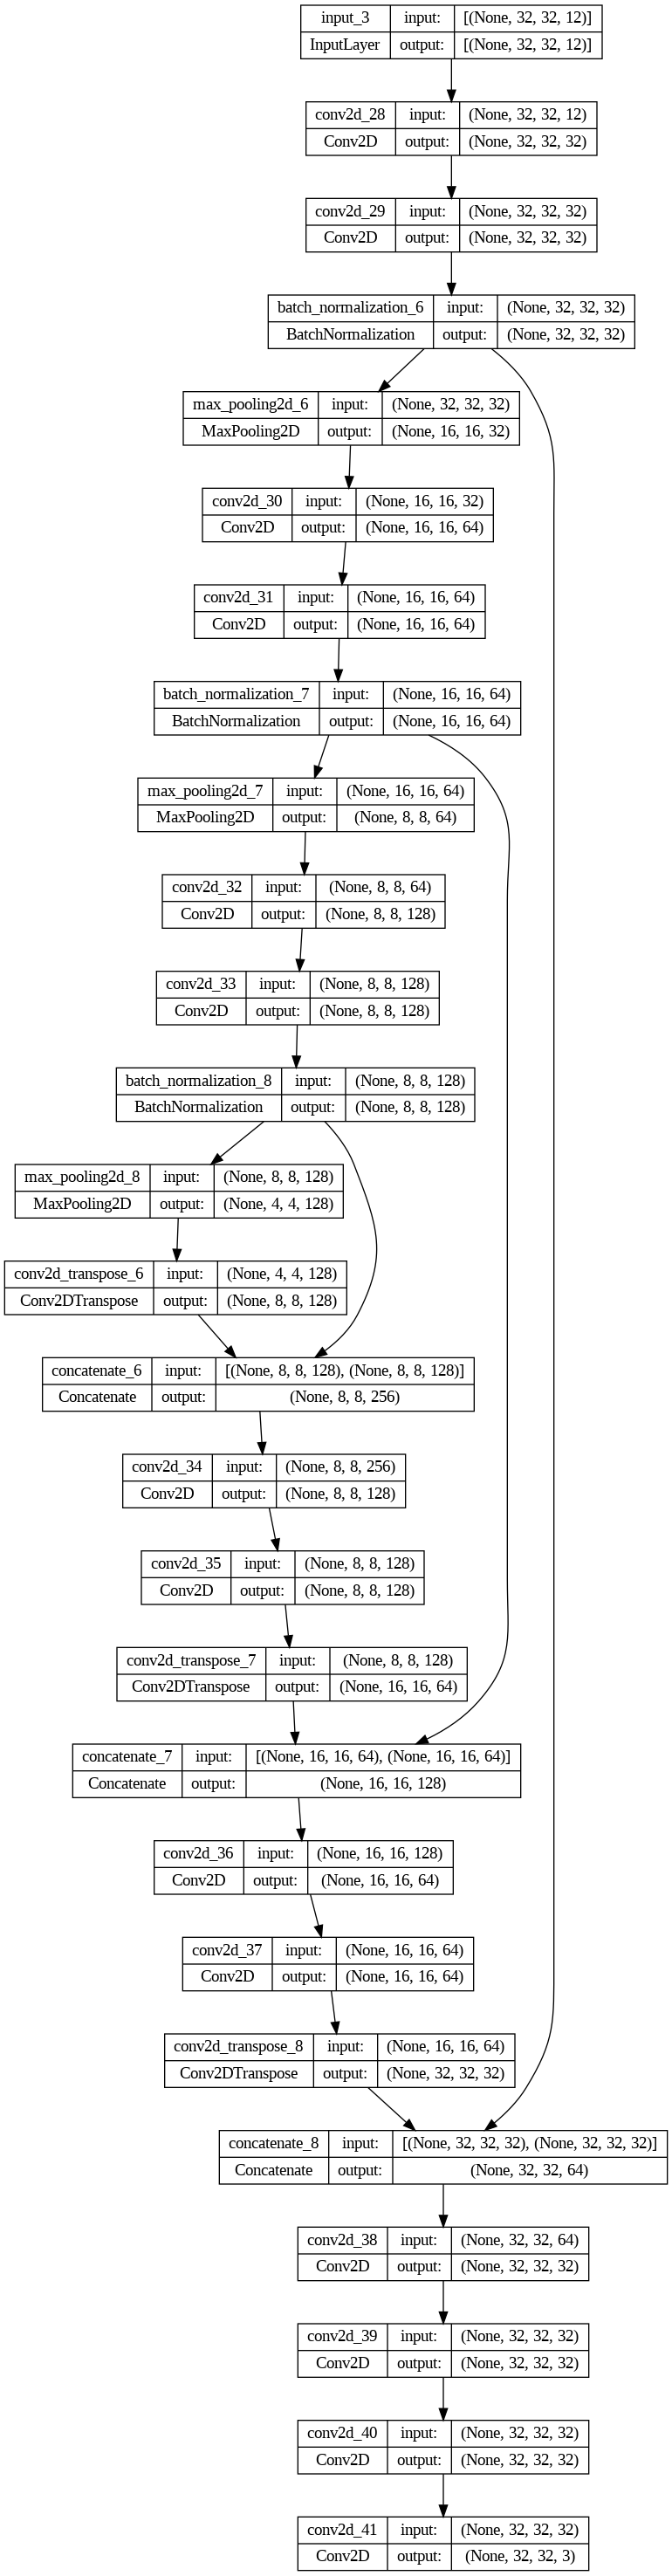

In [41]:
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

## Evaluation on Test Dataset

In [22]:
import torch
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
def binaryMaskIOU_(mask1, mask2):
    mask1 = mask1//2
    # print(np.unique(mask1))
    # pass
    mask1_area = torch.count_nonzero(mask1)
    mask2_area = torch.count_nonzero(mask2)
    
    intersection = torch.count_nonzero(torch.logical_and(mask1, mask2))
    iou = intersection / (mask1_area + mask2_area - intersection)
    return iou

In [107]:
Y_true = []
Y_pred = []
target_names = ['unknown', 'no fire', 'too much fire']

for x_batch_val, y_batch_val in test_dataset:
    val_logits = model(x_batch_val, training=False)
    val_loss_value = loss_fn(y_batch_val, val_logits)
    pred_mask = tf.argmax(val_logits, axis=-1)  ## Imp
    # print(pred_mask)
    # print(y_batch_val)
    # print()
    print(binaryMaskIOU_(torch.from_numpy(np.array(pred_mask)), torch.from_numpy(np.array(y_batch_val))))
    # print(np.unique(np.array(pred_mask)[1]))
    # break
    y_pred = (np.array(pred_mask))
    y_pred_flt = (np.array(pred_mask).flatten())
    y_true_flt = (np.array(y_batch_val).flatten())
    y_true = (np.array(y_batch_val))
    Y_true.extend(y_true_flt)
    Y_pred.extend(y_pred_flt)

print(classification_report(Y_true, Y_pred, target_names=target_names))

tensor(0.0070)
tensor(0.0084)
tensor(0.0057)
tensor(0.0103)
tensor(0.0099)
tensor(0.0083)
tensor(0.0080)
tensor(0.0082)
tensor(0.0133)
tensor(0.0157)
tensor(0.0222)
tensor(0.0201)
tensor(0.0203)
tensor(0.0090)
tensor(0.0050)
tensor(0.0019)
               precision    recall  f1-score   support

      unknown       0.00      0.00      0.00     38072
      no fire       0.96      0.99      0.98   1567251
too much fire       0.49      0.26      0.34     33077

     accuracy                           0.96   1638400
    macro avg       0.48      0.42      0.44   1638400
 weighted avg       0.93      0.96      0.94   1638400



In [24]:
def pallete_plt(tf_var, pallete):
    tr = np.array(tf_var).copy()
    tr = tr.astype(np.uint)
    return palette[tr]

In [ ]:
f = 35
idx = [35, 49, 60, 15, 70]
palette = np.array([[  0,   0,   0],   # black
                    [255, 255, 255],   # White
                    [  255, 0,   0]])   # Red


fig, arr = plt.subplots(2, len(idx),  figsize=(12, 4.5), gridspec_kw = {'wspace':0.1, 'hspace':0.1})

for n, id in enumerate(idx):
    arr[0,n].imshow(pallete_plt(y_batch_val[id,:,:], palette))
    arr[1,n].imshow(pallete_plt(pred_mask[id,:,:], palette))

arr[0,0].set_ylabel('Actual Wildfire Mask')
arr[1,0].set_ylabel('Predicted Wildfire Mask')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

plt.savefig('Prediction.png')
plt.show()
